In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import torch.optim as optim

# Time parameters
T = 10.0
dt = 0.01
t = np.arange(0, T, dt)

# Nonlinear system: m*x'' + c(v)*v + k(x)*x = d(t)
def nonlinear_system(t, y, d_func):
    x, v = y
    d = d_func(t)
    m = 1.0
    c = 0.5 + 0.1 * v**2  # Nonlinear damping
    k = 2.0 + 0.5 * x**2  # Nonlinear spring
    dxdt = v
    dvdt = (d - c * v - k * x) / m
    return [dxdt, dvdt]

def generate_trajectory(d_func):
    sol = solve_ivp(fun=lambda t, y: nonlinear_system(t, y, d_func),
                    t_span=(0, T), y0=[0.0, 0.0], t_eval=t, method='RK45')
    return sol.y.T

# Generate dataset
n_samples = 200
X, Y = [], []
for _ in range(n_samples):
    u = np.random.randn(len(t)) * 0.5
    d_func = lambda t_val: np.interp(t_val, t, u)
    traj = generate_trajectory(d_func)
    X.append(u)
    Y.append(traj[:, 0])  # output: position x(t)

X = np.array(X)
Y = np.array(Y)

# Neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.net(x)

# Train model
model = SimpleNN(len(t))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

for epoch in range(500):
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = criterion(output, Y_tensor)
    loss.backward()
    optimizer.step()

print("Final training loss:", loss.item())

# Estimate worst-case gain of learned model
def empirical_gain(model, n_trials=500):
    max_gain = 0.0
    for _ in range(n_trials):
        d = np.random.randn(len(t))
        d_norm = np.linalg.norm(d)
        d_unit = d / (d_norm + 1e-8)
        with torch.no_grad():
            d_tensor = torch.tensor(d_unit[None, :], dtype=torch.float32)
            y = model(d_tensor).numpy().squeeze()
        gain = np.linalg.norm(y) / (np.linalg.norm(d_unit) + 1e-8)
        max_gain = max(max_gain, gain)
    return max_gain

gamma_empirical = empirical_gain(model)
print(f"Empirical worst-case gain of the learned model: {gamma_empirical:.3f}")


Final training loss: 1.50017813211889e-05
Empirical worst-case gain of the learned model: 1.514


6.049667584646656
1062.0295474085103
1062.0295474085103


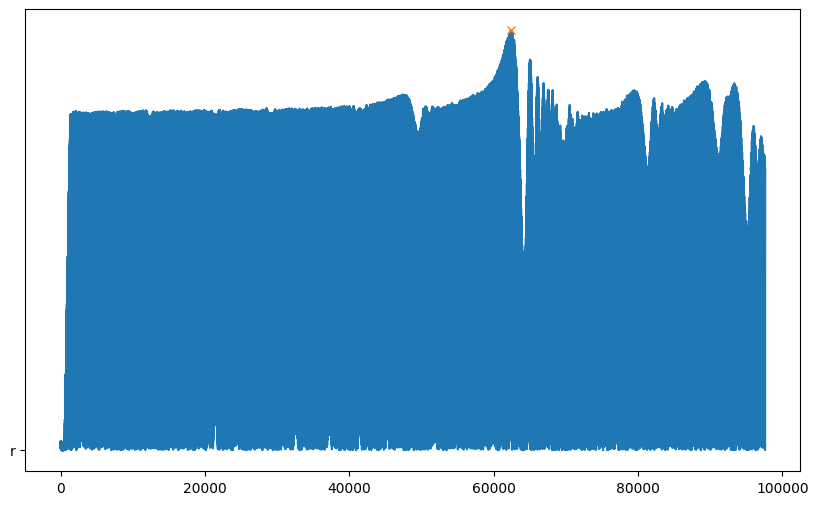

In [35]:
from crnn.data_io import load_data
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

dataset_dir = '/Users/jack/datasets/F16/in-distribution/processed'
input_names = ['u_1']
output_names = ['y_1', 'y_2', 'y_3']

data = load_data(input_names, output_names, 'train', dataset_dir)

d_raw = data.d[0]



def peak_norm(d:NDArray[np.float64])-> np.float64:
    return np.max(np.linalg.norm(d, axis=1))

def l2_norm(d:NDArray[np.float64]) -> np.float64:
    return np.sqrt(np.sum(np.linalg.norm(d, axis=1)**2))

def l2rho_norm(d:NDArray[np.float64], rho:np.float64 = 1.0) -> np.float64:
    return np.sqrt(np.sum([rho**(-2*k) * np.linalg.norm(d_k)**2 for k, d_k in enumerate(d)]))

    

print(peak_norm(d_raw))
print(l2_norm(d_raw))
print(l2rho_norm(d_raw,1))

fig, ax = plt.subplots(figsize=(10,6))
pos = np.argmax(np.linalg.norm(d_raw,axis=1))
ax.plot(np.linalg.norm(d_raw,axis=1))
ax.plot(pos, peak_norm(d_raw), 'x', 'r')


97629


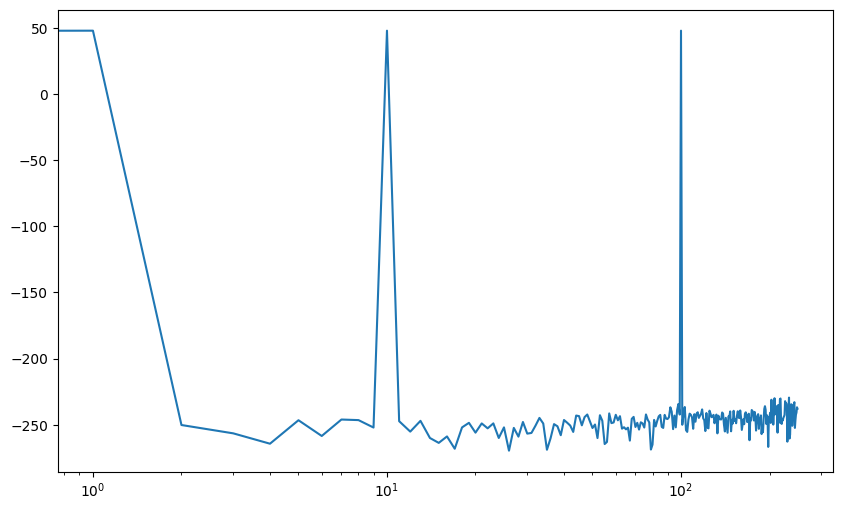

In [125]:
print(len(d_raw))
h, T = 500, 1
d = d_raw[:h]
t = np.linspace(0,T-T/h,h)
sin_ = lambda t, f: np.sin(2*np.pi*f*t)
cos_ = lambda t, f: np.cos(2*np.pi*f*t)
d = sin_(t,1) + sin_(t,100) + cos_(t,10) 
fig, ax = plt.subplots(figsize=(10,6))
# ax.plot(d)

# D_fft = np.fft.fft(d)
# freqs = np.fft.fftfreq(h,d = t[1]-t[0] )
# print(len(freqs))
# print(freqs)

D = np.zeros_like(d, dtype=complex)
for k in range(h):
    D[k] = np.sum([d_n * np.exp(-2j*np.pi*k/h*n) for (n, d_n)  in enumerate(d)])

# np.linalg.norm(D - D_fft,2)
dt = t[1]-t[0]
# print(dt)
freq = np.array([k/(h*dt) for k in range(h)])
# print(freq)
# print(len(freq))
ax.semilogx(freq[:h//2],20*np.log10(np.abs(D[:h//2])))






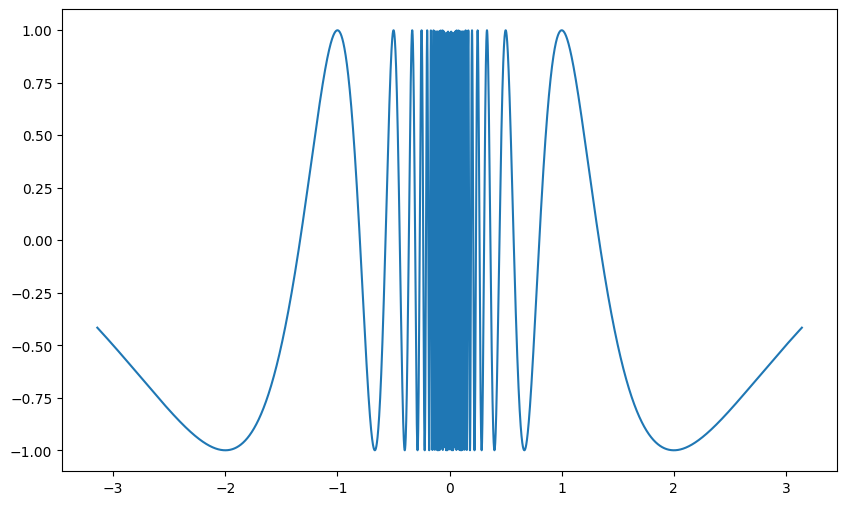

In [48]:
w_n = lambda n: np.exp(-2j*np.pi/n)
n = np.linspace(-np.pi,np.pi, 10000)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n,w_n(n))

In [51]:
f = 1/(2*np.pi)
f

0.15915494309189535

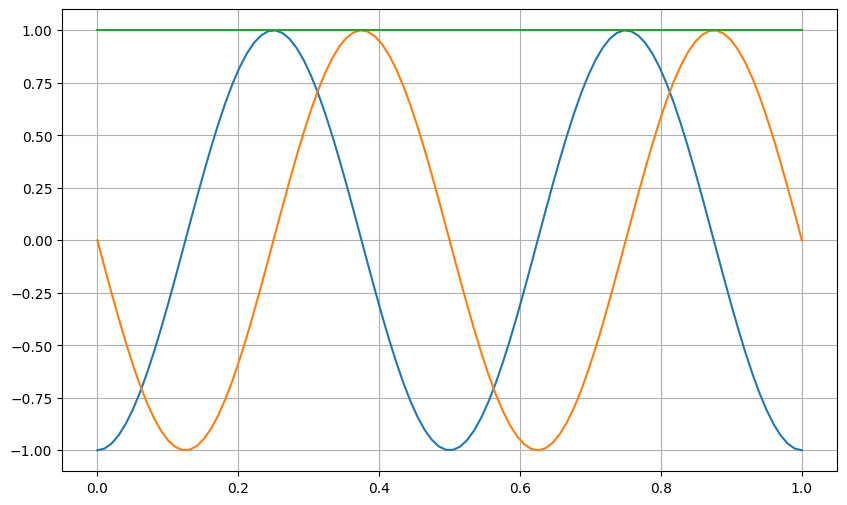

In [74]:


# exp_ = lambda t, f: np.cos(2*np.pi*t*f)+1j*np.sin(2*np.pi*t*f)
exp2_ = lambda t,f: -np.exp(2*np.pi*1j*f*t)
f = 1
t = np.linspace(0,1,100)
fig, ax = plt.subplots(figsize=(10,6))

# ax.plot(t, np.real(exp_(t,f)))
# ax.plot(t, np.imag(exp_(t,f)))

ax.plot(t, np.real(exp2_(t,2)))
ax.plot(t, np.imag(exp2_(t,2)))
ax.plot(t, np.abs(exp2_(t,2)))
ax.grid()


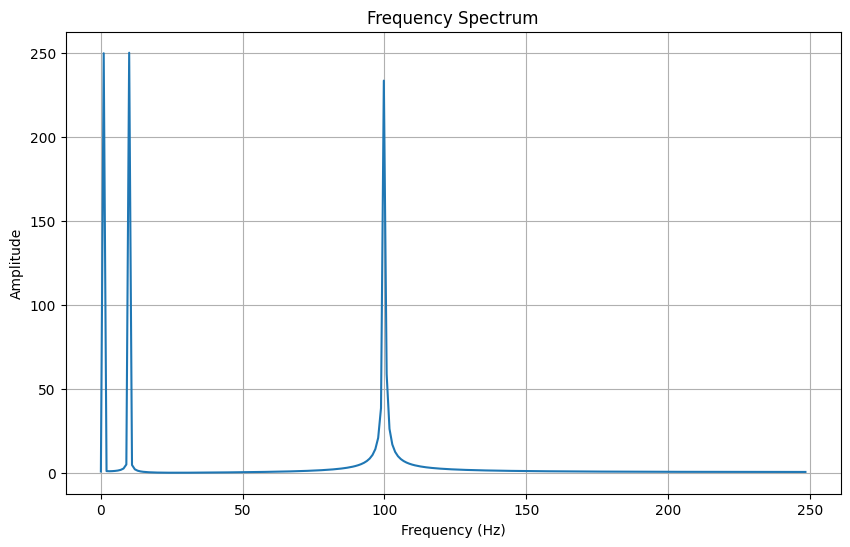

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# your original signal
h = 500
t = np.linspace(0,1,h)
sin_ = lambda t, f: np.sin(2*np.pi*f*t)
cos_ = lambda t, f: np.cos(2*np.pi*f*t)
d = sin_(t,1) + sin_(t,100) + cos_(t,10)

# compute the FFT
D_fft = np.fft.fft(d)
freqs = np.fft.fftfreq(h, d=(t[1] - t[0]))  # calculate the frequency bins

# plot
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(freqs[:h//2], np.abs(D_fft[:h//2]))  # only plot the positive frequencies
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.set_title('Frequency Spectrum')
plt.grid(True)
plt.show()

<>:52: SyntaxWarning: invalid escape sequence '\e'
<>:52: SyntaxWarning: invalid escape sequence '\e'
/var/folders/20/k44l3vsj03x1v_37v25mlp4w0000gn/T/ipykernel_12905/2743369964.py:52: SyntaxWarning: invalid escape sequence '\e'
  plt.suptitle(f"Stable Nonlinear System with High $\ell_2$-Gain: {l2_gain:.2f}")
/var/folders/20/k44l3vsj03x1v_37v25mlp4w0000gn/T/ipykernel_12905/2743369964.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = C @ x_nl + D @ [u[i]]


[0.94175368 0.94175368]


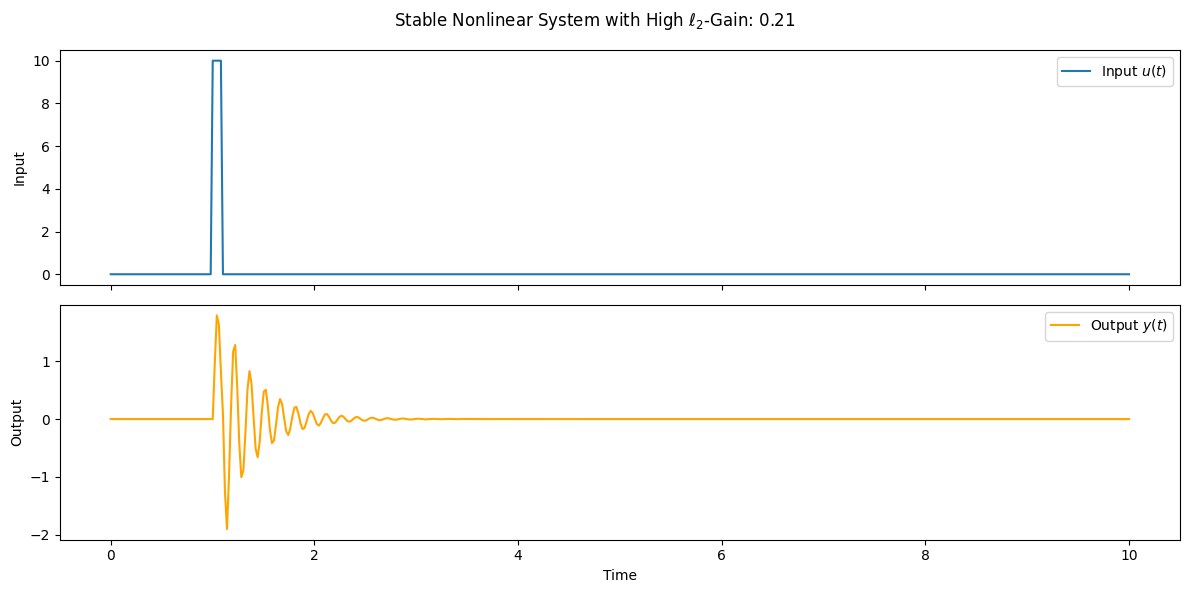

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lsim, StateSpace
from scipy.linalg import norm

# Define a 2D stable LTI system with a nonlinearity
A = 0.7*np.array([[0.9, -1.0],
              [1.0,  0.9]])
B = np.array([[0.1],
              [0.0]])
C = np.array([[1.0, 0.0]])
D = np.array([[0.0]])

print(np.abs(np.linalg.eig(A)[0]))

# Nonlinearity: saturated activation (like tanh or cubic)
def static_nonlinearity(x):
    # return np.tanh(x)  + 0.2 * x**3
    return np.tanh(x) + 0.2*x**3

# Time vector
t = np.linspace(0, 10, 500)
dt = t[1] - t[0]

# Input signal: short pulse
u = np.zeros_like(t)
u[50:55] = 10.0  # short, high input burst

# Simulate the nonlinear system
x = np.zeros((2, len(t)))
y = np.zeros(len(t))

for i in range(1, len(t)):
    x[:, i] = A @ x[:, i-1] + B.flatten() * u[i-1]
    x_nl = static_nonlinearity(x[:, i])
    y[i] = C @ x_nl + D @ [u[i]]

# Compute L2-gain
input_energy = norm(u)
output_energy = norm(y)
l2_gain = output_energy / input_energy

# Plot
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axs[0].plot(t, u, label="Input $u(t)$")
axs[0].set_ylabel("Input")
axs[0].legend()
axs[1].plot(t, y, label="Output $y(t)$", color='orange')
axs[1].set_ylabel("Output")
axs[1].set_xlabel("Time")
axs[1].legend()
plt.suptitle(f"Stable Nonlinear System with High $\ell_2$-Gain: {l2_gain:.2f}")
plt.tight_layout()
plt.show()


In [19]:
(C @x).shape
# t.shape

(1, 1000)

[0.96695398 0.96695398]
L2 gain ≈ 1401.70


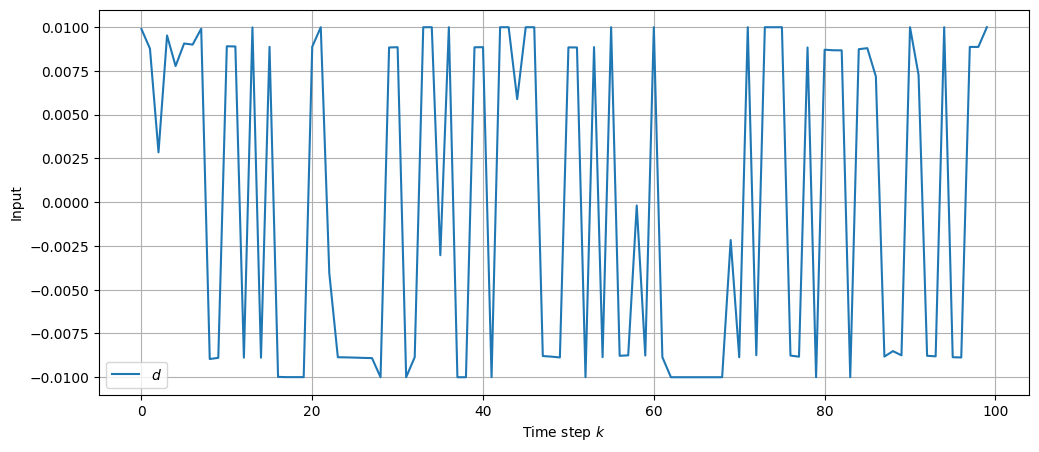

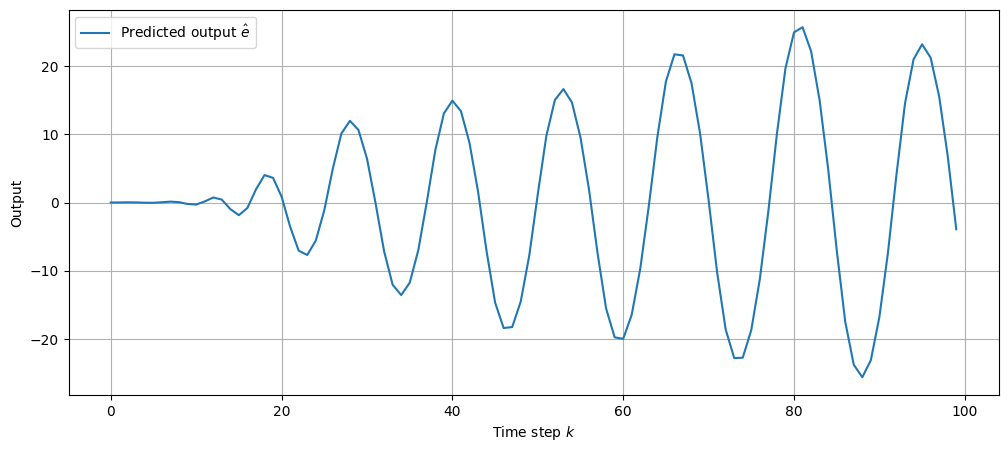

In [105]:
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import norm
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds

# Define the system (Lure system: LTI with nonlinearity in feedback)
A = np.array([[0.9, 0.1], [-0.8, 0.95]])
print(np.abs(np.linalg.eig(A)[0]))
B = np.array([[1.], [20]])
C = np.array([[1, 0.0]])

def simulate_lure_from_input(u_input, x0=None):
    u_input = np.array(u_input).reshape(-1, 1)  # Ensure shape (N, 1)
    N = u_input.shape[0]
    if x0 is None:
        x0 = np.zeros((A.shape[0],))
    x = x0.reshape(-1, 1)
    x_hist = []
    y_hist = []
    
    for t in range(N):
        y = C @ x
        u_nl = u_input[t] - np.tanh(y)
        # u_nl = np.tanh(y)
        x = A @ x + B * u_nl
        # print(f'x{x}, u {u_nl}')
        x_hist.append(x.flatten())
        y_hist.append(y.flatten())
    
    return np.array(x_hist), np.array(y_hist).flatten()

# Objective: maximize L2 norm of output by optimizing input signal
N = 100  # Length of input signal
def l2_gain_input_objective(u_flat):
    try:
        _, y_out = simulate_lure_from_input(u_flat)
        return -norm(y_out, ord=2)  # Negative for maximization
    except Exception as e:
        print("Simulation error:", e)
        return 0

# Initial guess: small random input
u0 = 0.1 * np.random.randn(N)

dt = 1
t = np.linspace(0,(N-1)*dt, N)

# Optimize input signal
# Bounds for each input element
u_bound = 0.01
bounds = Bounds(-u_bound * np.ones(N), u_bound * np.ones(N))

# Optimize using L-BFGS-B with bounds
res = minimize(
    l2_gain_input_objective,
    u0,
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 1200}
)
# res = minimize(l2_gain_input_objective, u0, method='Powell', options={'maxiter': 5})

u_opt = res.x
# extend = 100
# u_opt= np.hstack((u_opt, np.zeros((extend,),dtype=np.float64)))
# u_opt = u0
_, y_opt = simulate_lure_from_input(u_opt)

# Plot results
import tikzplotlib
import os
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(t,u_opt, label='$d$')
ax.set_ylabel('Input')
ax.set_xlabel('Time step $k$')
ax.grid()
ax.legend()

result_folder = '/Users/jack/cloud_privat/03_Promotion/05_Reports/presentation/presentation.latex.status/2025_05_13-NonlinearSysId-workshop/fig/l2-amplification'

tikzplotlib.save(os.path.join(result_folder, 'critical_l2_input.tex'))

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(t,y_opt, label=r'Predicted output $\hat e$')
ax.set_ylabel('Output')
ax.set_xlabel('Time step $k$')
ax.grid()
ax.legend()

tikzplotlib.save(os.path.join(result_folder, 'critical_l2_output.tex'))

# Report L2 gain
l2_gain = norm(y_opt, ord=2) / norm(u_opt, ord=2)
print(f"L2 gain ≈ {l2_gain:.2f}")


In [47]:
u_opt.shape
u_opt = np.hstack((u_opt, np.zeros((10,))))
u_opt.shape

(120,)

In [24]:
u_opt
y_opt

array([ 0.00000000e+000,  7.75332972e+307,  8.52866270e+307,
        8.99386248e+307,  9.17606573e+307,  9.10609193e+307,
        8.81721255e+307,  8.34401279e+307,  7.72136267e+307,
        6.98350976e+307,  6.16330071e+307,  5.29153528e+307,
        4.39645214e+307,  3.50334309e+307,  2.63428910e+307,
        1.80800963e+307,  1.03981485e+307,  3.41649044e+306,
       -2.77787259e+306, -8.12849343e+306, -1.26070743e+307,
       -1.62106558e+307, -1.89585231e+307, -2.08889440e+307,
       -2.20558386e+307, -2.25254755e+307, -2.23732708e+307,
       -2.16807600e+307, -2.05327940e+307, -1.90150040e+307,
       -1.72115625e+307, -1.52032622e+307, -1.30659179e+307,
       -1.08690937e+307, -8.67514513e+306, -6.53856153e+306,
       -4.50558684e+306, -2.61409431e+306, -8.93685994e+305,
        6.34013435e+305,  1.95490010e+306,  3.06180343e+306,
        3.95379875e+306,  4.63544970e+306,  5.11600803e+306,
        5.40859637e+306,  5.52939626e+306,  5.49686125e+306,
        5.33097159e+306,